In [206]:
import numpy as np
import cv2
from matplotlib import pyplot as plt

## Read images

(484, 269, 3)

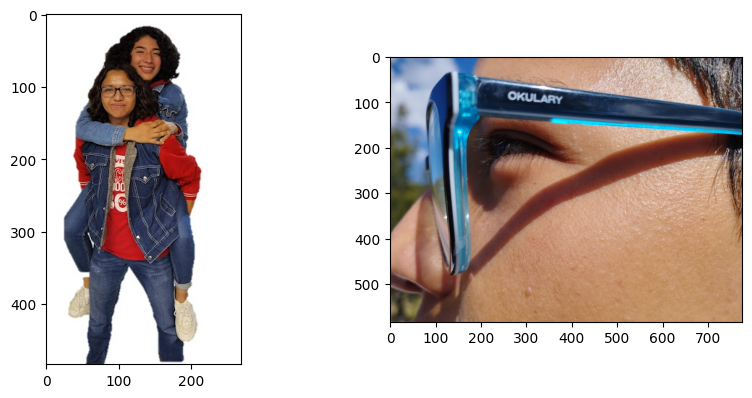

In [207]:
fig = plt.figure(figsize=(10,10))

tattoo = cv2.imread("../../data/Us.jpg")
o = fig.add_subplot(2,2,1)
tattoo = tattoo[100:, :]
o.imshow(cv2.cvtColor(tattoo, cv2.COLOR_BGR2RGB))

skin = cv2.imread("../../data/Me.jpg")
a = fig.add_subplot(2,2,2)
a.imshow(cv2.cvtColor(skin, cv2.COLOR_BGR2RGB))
tattoo.shape

## Preview

The idea is to tattoo that pic on my face

(484, 269, 3)


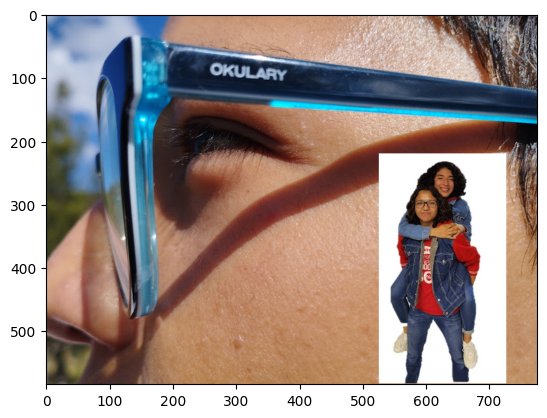

In [208]:
print(tattoo.shape)
s = 0.75
dim = np.array([tattoo.shape[1]*s, tattoo.shape[0]*s])
dim = dim.astype(int)

skinT = np.copy(skin)
p = cv2.resize(tattoo, dim)
x, y = 525, 220
skinT[y :p.shape[0] + y, x :p.shape[1] + x] = p
plt.imshow(cv2.cvtColor(skinT, cv2.COLOR_BGR2RGB))


## Design tattoo

Setting the second image up in order to fit on the first one.

In [209]:
threshold = 180
mask = cv2.cvtColor(tattoo, cv2.COLOR_BGR2GRAY)
_, mask = cv2.threshold(mask, threshold, threshold, cv2.THRESH_BINARY)
mask = mask/threshold
mask[300:] = mask[300:]+0.3
mask[350:] = mask[350:]+0.3
mask[400:] = mask[400:]+0.3
for i in range(mask.shape[0]):        
    for j in range(mask.shape[1]):        
        mask[i, j] = np.min((mask[i, j], 1))
mask[300:] = cv2.filter2D(mask[300:], ddepth = -1, kernel = np.array([[1, 1, 1, 1, 1], [1, 1, 1, 1, 1], [1, 1, 1, 1, 1], [1, 1, 1, 1, 1], [1, 1, 1, 1, 1]])/25)
mask = cv2.filter2D(mask, ddepth = -1, kernel = np.array([[1, 2, 1], [2, 4, 2], [1, 2, 1]])/16)


In [210]:
print(tattoo.shape)
s = 0.75
dim = np.array([tattoo.shape[1]*s, tattoo.shape[0]*s])
dim = dim.astype(int)

tattoo = cv2.resize(tattoo, dim)
back = np.zeros_like(skin)
back[y :tattoo.shape[0] + y, x :tattoo.shape[1] + x] = tattoo
tattoo = np.copy(back)

(484, 269, 3)


(484, 269)


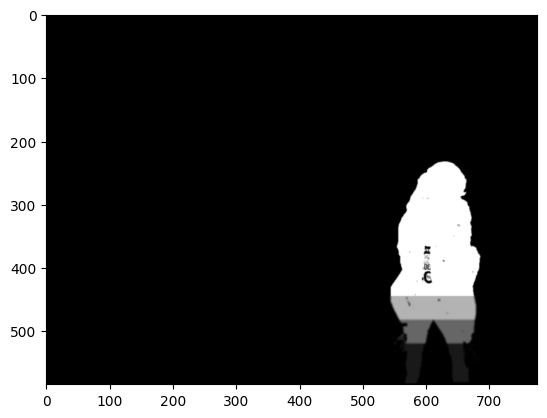

In [211]:
print(mask.shape)
mask = cv2.resize(mask, dim)
back = np.zeros((skin.shape[0], skin.shape[1]))
back[y :mask.shape[0] + y, x :mask.shape[1] + x] = 1 - mask
mask = np.copy(back)
plt.imshow(mask, cmap = "gray")

## Creation of the pyramids, blending image

In [212]:
nLevels = 3

In [213]:
s = np.copy(skin)
gpSkin = [s]
for i in range(nLevels):
    s = cv2.pyrDown(s)
    gpSkin.append(s)

In [214]:
t = np.copy(tattoo)
gpTattoo = [t]
for i in range(nLevels):
    t = cv2.pyrDown(t)
    gpTattoo.append(t)

In [215]:
m = np.copy(mask)
gpMask = [m]
for i in range(nLevels - 1):
    m = cv2.pyrDown(m)
    gpMask.append(m)

In [216]:
lpSkin = [gpSkin[nLevels - 1]]
for i in range(nLevels - 1, 0, -1):
    bS = cv2.pyrUp(gpSkin[i], dstsize = (gpSkin[i-1].shape[1], gpSkin[i-1].shape[0]))
    l = cv2.subtract(gpSkin[i-1], bS)
    lpSkin.append(l)

In [217]:
lpTattoo = [gpTattoo[nLevels - 1]]
for i in range(nLevels - 1, 0, -1):
    bT = cv2.pyrUp(gpTattoo[i], dstsize = (gpTattoo[i-1].shape[1], gpTattoo[i-1].shape[0]))
    l = cv2.subtract(gpTattoo[i-1], bT)
    lpTattoo.append(l)

In [218]:
lFinal = []
for gM, l in zip(gpMask[::-1], zip(lpSkin, lpTattoo)):
    lS, lT = l
    gM = np.stack([gM, gM, gM], -1)
    lF = np.add(np.multiply(lS, (1 - gM)), np.multiply(lT, gM))
    lFinal.append(lF)

In [219]:
r = lFinal[0]
for i in range(1, nLevels):
    r = cv2.pyrUp(r, dstsize=(lpSkin[i].shape[1], lpSkin[i].shape[0]))
    r = np.add(lFinal[i], r) 

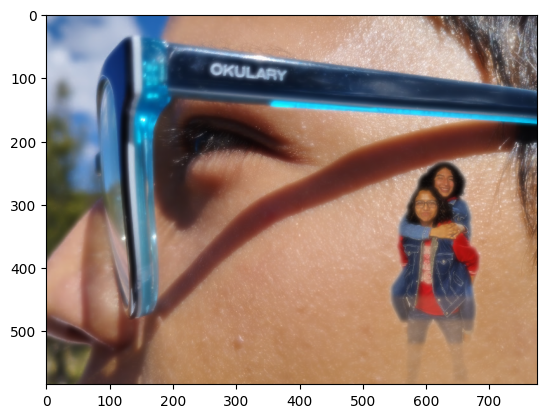

In [220]:
r = r / np.max(r)
r = r.astype('float32')
plt.imshow(cv2.cvtColor(r, cv2.COLOR_BGR2RGB))